In [1]:
# first, read in the data

import os
import csv

os.chdir('../data/')

records = []

with open('call_records.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        records.append(row)

print(records[0]) # print the header
records = records[1:] # remove the header
print(records[0]) # print an example record

['time', 'cell', 'from', 'to']
['0', '186', '974-703-1399', '876-251-8837']


In [2]:
all_numbers = list(set([r[2] for r in records]))

def calc_calls_per_hour(records):
    call_times = [int(r[0]) for r in records]
    first_call = min(call_times)
    last_call = max(call_times)
    total_calls = len(call_times)
    active_duration = last_call - first_call
    calls_per_hour = total_calls / active_duration
    return calls_per_hour

cph = []
for number in all_numbers:
    n_calls_hour = calc_calls_per_hour([r for r in records if r[2] == number])
    cph.append(n_calls_hour)

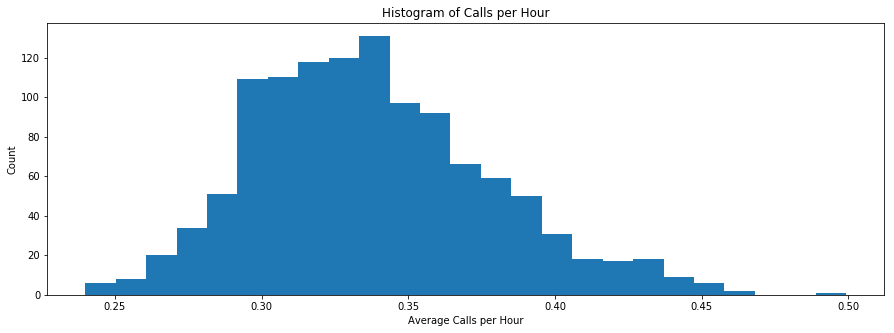

In [3]:
import matplotlib.pyplot as plt # import our graphing module
plt.rcParams["figure.figsize"] = (15,5) # set the default figure size

n, bins, patches = plt.hist(cph, 25)

plt.xlabel('Average Calls per Hour')
plt.ylabel('Count')
plt.title('Histogram of Calls per Hour')
plt.show()

In [4]:
def calc_num_friends(records):
    recipients = [r[3] for r in records]
    uniq_recipients = sorted(list(set(recipients)))
    freq = [recipients.count(x) for x in uniq_recipients]
    average_freq = sum(freq) / len(freq)
    friends = [x for (x,y) in zip(uniq_recipients, freq) if y > average_freq]
    return len(friends)

num_friends = []
for num in all_numbers:
    num_friends.append(calc_num_friends([r for r in records if r[2] == num]))

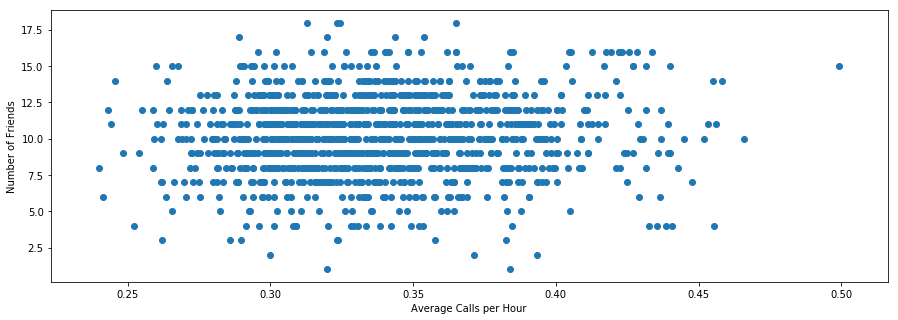

In [5]:
plt.scatter(cph, num_friends)

plt.xlabel('Average Calls per Hour')
plt.ylabel('Number of Friends')
plt.show()

Oof. That's going to be a rough cloud to try to cluster, but we can see what happens. Perhaps if you added more features, you'd be able to find a pattern in the data. :)

In [9]:
from sklearn import preprocessing
import numpy as np

%store -r similarity_matrix

# build the feature vectors
cph = preprocessing.minmax_scale(cph)
num_friends = preprocessing.minmax_scale(num_friends)

data = [[a, b, *c] for (a, b, c) in zip(cph, num_friends, similarity_matrix)]
data = np.array(data)

We're now normalizing the data, so that the range of the number of friends (0 to ~18) doesn't overwhelm the calls per hour (which max out around 0.5).

In [11]:
plt.scatter(*zip(*data))

plt.xlabel('Average Calls per Hour')
plt.ylabel('Number of Friends')
#plt.title('Histogram of Calls per Hour')
plt.show()

TypeError: scatter() takes from 2 to 15 positional arguments but 1175 were given

In [12]:
from sklearn import decomposition

# reduce our 1175-dimensional model to a 20-dimensional model
# see: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA
reduced_data = decomposition.PCA(n_components=3).fit_transform(data)

In [13]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(reduced_data, quantile=0.5, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(reduced_data)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = list(set(labels))
n_clusters = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters)


# alternatively, do the clustering with k means
#from sklearn import cluster as clu
#n_clusters = 10
#cluster_output = clu.k_means(data, n_clusters=n_clusters, max_iter=1000)
#labels = cluster_output[1]
#cluster_centers = cluster_output[0]
#print(labels)

# we now have labels, and need to turn that into phone numbers
results = [[] for x in range(n_clusters+1)]
for i,label in enumerate(labels):
    # for each label, grab the number it represents (all_numbers[i]) and
    # put it in the right cluster list (results[label])
    results[label].append(all_numbers[i])
  
for result in results:
    print(result)
    
%store all_numbers
%store labels

number of estimated clusters : 11
['401-843-0706', '286-062-5389', '852-887-5191', '538-762-6512', '964-103-3461', '159-156-1635', '676-573-2861', '437-154-6017', '423-520-8560', '235-616-7350', '625-447-2187', '927-700-6780', '763-267-2223', '833-764-2752', '923-543-3302', '148-323-1555', '873-755-5667', '200-814-8053', '570-110-8282', '301-055-5394', '755-007-4637', '965-181-6194', '141-673-7485', '492-678-8812', '164-718-0238', '304-547-9323', '229-227-8346', '174-382-1893', '819-482-6755', '215-083-4074', '854-105-2245', '109-400-8113', '846-265-6915', '193-388-2710', '421-511-6313', '257-315-8583', '843-536-0183', '384-766-3919', '318-247-0764', '939-680-4390', '240-580-8201', '328-846-7086', '825-671-5922', '332-844-6395', '305-032-7007', '764-121-8003', '647-286-8112', '227-422-6754', '790-505-0158', '212-262-5861', '218-817-5883', '110-733-0649', '643-077-7878', '720-434-4823', '551-523-3550', '569-021-5832', '322-244-4582', '436-504-3436', '214-264-8103', '118-083-6411', '427-

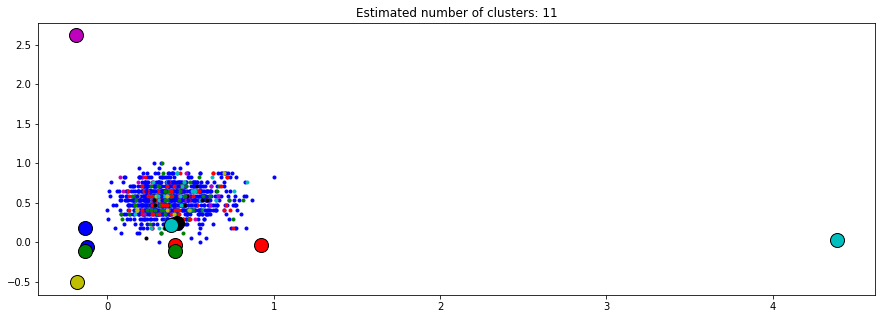

In [14]:
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(data[my_members, 0], data[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters)
plt.show()

So there are your clusters! The large dots represent the center points of the clusters, and the colored data points each correspond to what cluster they're in. Are they any good? Well... I checked some of them, and let's just say they're better than random, but not by a lot. Looks like there's work to be done here!